In [1]:
%pylab inline
import gc
import pandas as pd
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.optimizers import Adam, Nadam
import seaborn as sns
from scipy.sparse import csr_matrix
from datetime import timedelta
from keras import backend as K
from keras import losses, metrics, callbacks
from sklearn.decomposition import PCA

K.tensorflow_backend._get_available_gpus()
from tqdm import tqdm_notebook
from tqdm.autonotebook import tqdm
tqdm.pandas()

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 3} ) 
sess = tf.Session(config=config) 
K.set_session(sess)

In [33]:
df_sales_train = pd.read_csv('../data/sales_train_evaluation.csv', dtype={f'd_{i}': np.int32 for i in range(0, 1948)})
# df_sell_prices = pd.read_csv('../data/sell_prices.csv')
df_calendar = pd.read_pickle('../data/processed/calendar_OHE.pkl')

In [4]:
df_sales_train = df_sales_train.rename(
    {i: j for i, j in df_calendar[['d', 'date']].to_dict(orient='split')['data']},
    axis=1)

In [5]:
df_sales_train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,2011-01-29,2011-01-30,2011-01-31,2011-02-01,...,2016-05-13,2016-05-14,2016-05-15,2016-05-16,2016-05-17,2016-05-18,2016-05-19,2016-05-20,2016-05-21,2016-05-22
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


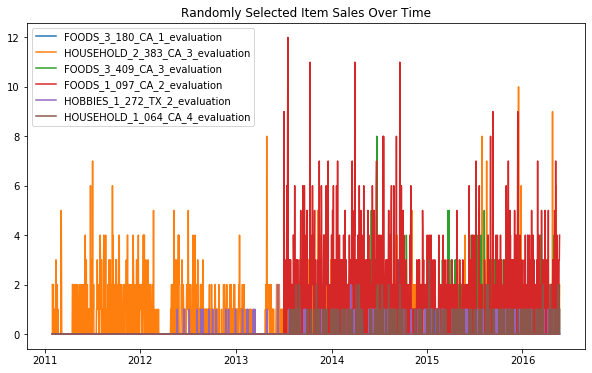

In [6]:
def plot_random_series(df, n_series):
    
    sample = df.sample(n_series, random_state=42)
    item_id = sample['id'].tolist()
    series_samples = sample.drop(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], axis=1)
    
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        pd.Series(series_samples.iloc[i]).astype(np.float64).plot(linewidth=1.5)
    
    plt.title('Randomly Selected Item Sales Over Time')
    plt.legend(item_id)
    
plot_random_series(df_sales_train, 6)

In [7]:
df_sales_train.columns.shape

(1947,)

## Feature Eng'g 

In [8]:
df_metadata = df_sales_train[['dept_id', 'cat_id', 'store_id', 'state_id']]

In [9]:
metadata_array = pd.get_dummies(df_metadata).values
pca = PCA(n_components=14)
metadata_array = pca.fit_transform(metadata_array)
metadata_array = np.expand_dims(metadata_array, axis=1) # add timesteps dimension
metadata_array = np.tile(metadata_array,(1,1969,1)).astype('float16')

In [10]:
metadata_array.shape

(30490, 1969, 14)

In [11]:
# # Decompose using PCA due to memory constraints.
# # Only repeat during batch processing/training
calendar_array = df_calendar.sort_values('date').drop(['date','wm_yr_wk', 'd'], axis=1).astype(int).values
calendar_array = PCA(n_components=3).fit_transform(calendar_array)
calendar_array = np.expand_dims(calendar_array, axis=0)
calendar_array = np.repeat(calendar_array, metadata_array.shape[0], axis=0).astype('float16')
calendar_array.shape

(30490, 1969, 3)

In [12]:
exog_array = np.concatenate([metadata_array, calendar_array], axis=2)

In [13]:
exog_array.nbytes

2041183540

In [14]:
del metadata_array
del calendar_array
del df_metadata
del df_calendar
gc.collect()

3584

In [15]:
def get_time_block_series(series_array, dadf_metadataindex, start_date, end_date, date_to_index):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array.astype(float16), series_mean.astype(float16)

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array.astype(float16)

In [16]:
def get_data_encode_decode(series_array, exog_array, first_n_samples,
                           date_to_index, enc_start, enc_end, pred_start, pred_end):

    exog_inds = date_to_index[enc_start:pred_end]
    
    # sample of series from enc_start to enc_end  
    encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                               enc_start, enc_end, date_to_index)[:first_n_samples]
    encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
    
    # sample of series from pred_start to pred_end 
    decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                                pred_start, pred_end, date_to_index)[:first_n_samples]
    decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)
    
    # we append a lagged history of the target series to the input data, 
    # so that we can train with teacher forcing
    lagged_target_history = decoder_target_data[:,:-1,:1]
    encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)
    
    # we add the exogenous features corresponding to day after input series
    # values to the input data (exog should match day we are predicting)
    exog_input_data = exog_array[:first_n_samples,exog_inds,:][:,1:,:]
    encoder_input_data = np.concatenate([encoder_input_data, exog_input_data], axis=-1)
    
    return encoder_input_data.astype(float16), decoder_target_data.astype(float16), encode_series_mean.astype(float16)

In [17]:
def generate_train_set_time_batch(start_idx=None):

    pred_steps = 28
    if start_idx is None:
        start_idx = np.random.randint(1396, 1498) # some random number + 6 but not greater than 1498
    start_date = df_sales_train.columns[start_idx]
    pred_length=timedelta(pred_steps)
    first_day = pd.to_datetime(start_date) 
    last_day = pd.to_datetime(df_sales_train.columns[start_idx + 365 + (pred_steps * 2)]) # 365 days + 28x2 pred_steps 
    val_pred_start = last_day - pred_length + timedelta(1)
    val_pred_end = last_day
    train_pred_start = val_pred_start - pred_length
    train_pred_end = val_pred_start - timedelta(days=1)
    enc_length = train_pred_start - first_day
    train_enc_start = first_day
    train_enc_end = train_enc_start + enc_length - timedelta(1)
    val_enc_start = train_enc_start + pred_length
    val_enc_end = val_enc_start + enc_length - timedelta(1)
    print('Train encoding:', train_enc_start, '-', train_enc_end)
    print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
    print('Val encoding:', val_enc_start, '-', val_enc_end)
    print('Val prediction:', val_pred_start, '-', val_pred_end)

    print('\nEncoding interval:', enc_length.days)
    print('Prediction interval:', pred_length.days)

    date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df_sales_train.columns[start_idx:]]),
                              data=[i for i in range(len(df_sales_train.columns[start_idx:]))])

    series_array = df_sales_train[df_sales_train.columns[start_idx:]].values
    print(enc_length)
    series_array.shape
    first_n_samples = df_sales_train.shape[0]

    encoder_input_data, decoder_target_data, encode_series_mean = \
        get_data_encode_decode(series_array, exog_array, first_n_samples, date_to_index, 
                               train_enc_start, train_enc_end, train_pred_start, train_pred_end)
    
    val_encoder_input_data, val_decoder_target_data, val_encode_series_mean = \
        get_data_encode_decode(series_array, exog_array, first_n_samples, date_to_index, 
                               val_enc_start, val_enc_end, val_pred_start, val_pred_end)
    
    return (
        (encoder_input_data.astype(float16), decoder_target_data.astype(float16), encode_series_mean.astype(float16)),
        (val_encoder_input_data.astype(float16), val_decoder_target_data.astype(float16), val_encode_series_mean.astype(float16))
    )

In [18]:
def tweedieloss(y_true, y_pred):
    p=1.5
    dev = 2 * (K.pow(y_true, 2-p)/((1-p) * (2-p)) -
                   y_true * K.pow(y_pred, 1-p)/(1-p) +
                   K.pow(y_pred, 2-p)/(2-p))
    return K.mean(dev)

In [19]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

In [20]:
# convolutional operation parameters
n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2 

# define an input history series and pass it through a stack of dilated causal convolution blocks. 
# Note the feature input dimension corresponds to the raw series and all exogenous features  
history_seq = Input(shape=(None, 1 + exog_array.shape[-1]))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(64, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(64, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)

# extract the last 28 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length': 28})(out)

model = Model(history_seq, pred_seq_train)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 18)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 64)     1216        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 32)     4128        conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, None, 32)     4128        conv1d_1[0][0]                   
____________________________________________________________________________________________

In [22]:
model.compile(Adam(), loss=losses.MeanSquaredError(), metrics=[metrics.RootMeanSquaredError()])

In [23]:
model.load_weights('../data/results/wavenet_exog')

In [24]:
# callback_earlystopping = callbacks.EarlyStopping(
#     monitor="val_loss",
#     min_delta=3e-4,
#     patience=3,
#     verbose=0,
#     mode="auto",
#     baseline=None,
#     restore_best_weights=True,
# )

In [25]:
epochs=10
batch_size=512

In [26]:
time_window = 4
for _ in range(10_000):
        train_val_ls = [generate_train_set_time_batch() for _ in range(time_window)]
        X_train = np.vstack([train_val_ls[i][0][0] for i in range(time_window)])
        y_train = np.vstack([train_val_ls[i][0][1] for i in range(time_window)])
        X_val = np.vstack([train_val_ls[i][1][0] for i in range(time_window)])
        y_val = np.vstack([train_val_ls[i][1][1] for i in range(time_window)])
        model.fit(X_train, y_train, validation_data=(X_val, y_val),
                            batch_size=batch_size,
                            epochs=epochs, callbacks=[
                                                    callbacks.ModelCheckpoint(filepath='../data/processed/model.{epoch:02d}.h5'),
                                                    callbacks.TensorBoard(log_dir='./logs'),])

        # Need to free up memory
        del train_val_ls
        del X_train
        del y_train
        del X_val
        del y_val
        gc.collect()

 35840/121960 [=======>......................] - ETA: 2:03 - loss: 0.1817 - root_mean_squared_error: 0.4263

KeyboardInterrupt: 

In [27]:
model.save('../data/results/wavenet_exog')

In [28]:
X_train.shape

(121960, 393, 18)

In [24]:
def normalize_sequence(input_series, encode_series_mean):

    input_series = np.squeeze(input_series)
    return np.expm1(input_series + encode_series_mean).round()


In [25]:
train, val = generate_train_set_time_batch(1525)

Train encoding: 2015-03-28 00:00:00 - 2016-03-27 00:00:00
Train prediction: 2016-03-28 00:00:00 - 2016-04-24 00:00:00 

Val encoding: 2015-04-25 00:00:00 - 2016-04-24 00:00:00
Val prediction: 2016-04-25 00:00:00 - 2016-05-22 00:00:00

Encoding interval: 366
Prediction interval: 28
366 days 00:00:00


In [26]:
preds = model.predict(val[0])

In [27]:
y_ = pd.DataFrame(normalize_sequence(preds, val[2]))
y_ = y_.fillna(0)

In [28]:
y_ = y_.rename({i: f'F{i+1}' for i in range(0, 28)}, axis=1)
y_['id'] = df_sales_train['id']

In [29]:
y_[['id'] + y_.drop('id', axis=1).columns.tolist()].to_csv('../data/results/wavenet_exog_2406.csv', index=False)

In [35]:
df_calendar['date']

0       2011-01-29
1       2011-01-30
2       2011-01-31
3       2011-02-01
4       2011-02-02
           ...    
1964    2016-06-15
1965    2016-06-16
1966    2016-06-17
1967    2016-06-18
1968    2016-06-19
Name: date, Length: 1969, dtype: object